# Contrastive Learning for Debiasing Genomic Embeddings

## Overview

This notebook implements supervised contrastive learning to improve pre-computed genomic embeddings by reducing confounding effects from ancestry and technical variables while preserving discriminative signal for the outcome of interest.

## Background

Genomic data often contains confounding factors (ancestry, sequencing batch, read depth, etc.) that can lead to spurious associations in downstream analyses. Traditional approaches like linear regression adjustment or propensity score matching have limitations. Contrastive learning offers an alternative: learn an embedding space where:

1. **Samples with the same phenotype** are pulled together (positive pairs)
2. **Samples with different phenotypes** but matched confounders are pushed apart (negative pairs)
3. **Confounder effects** are minimized through the matched design

## Study Design

We use a **matched case-control design** with:
- Cases: Samples with `is_positive = 1`
- Controls: 4 matched controls per case (matched on confounders)
- Each case-control group is identified by `case_matched` column

### Contrastive Pairs Definition

- **Positive pairs**: Two samples with the same `is_positive` label AND same `case_matched` group
- **Negative pairs**: Two samples with different `is_positive` labels AND same `case_matched` group

This ensures we're learning to discriminate between cases and controls while being invariant to the confounders they share.

## Training Strategy

1. Split data by `case_matched` groups (20% validation) to prevent leakage
2. Train a projection network using supervised contrastive loss
3. Monitor progress using cluster separation and logistic regression AUC
4. Compare embeddings before and after training using PCA visualizations

## Expected Outcome

The trained embeddings should:
- ✓ Improve separation between cases and controls (higher AUC)
- ✓ Reduce correlation with confounding variables
- ✓ Maintain or improve downstream predictive performance

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading

Load the parquet file containing pre-computed embeddings and metadata. The data should include:
- **Embeddings**: Pre-computed feature vectors (e.g., from a variant autoencoder, PRS, or other genomic model)
- **is_positive**: Binary outcome label (1 = case, 0 = control)
- **case_matched**: Group ID linking each case to its matched controls
- **Confounders**: Variables to control for (ancestry, batch, read depth, etc.)

In [3]:
data_path = "/home/ext_meehl_joshua_mayo_edu/strand_cohort_eda/genomic/evals/data/embeddings/t1d/t1d_v1_emb_matrix_named.parquet"
meta_path = "/home/ext_meehl_joshua_mayo_edu/strand_cohort_eda/genomic/evals/data/gsm/t1d/matched_has_diabetes1_v4_modified.csv"
cofound_path = "/home/ext_meehl_joshua_mayo_edu/strand_cohort_eda/genomic/datasets/golden_benchmark/data/cohort_design/master_cohort.csv"

In [4]:
# Load the parquet file
# UPDATE THIS PATH to your actual parquet file
parquet_path = data_path
df_emb = pd.read_parquet(parquet_path)

print(f"Dataset shape: {df_emb.shape}")
print(f"\nColumns: {df_emb.columns.tolist()}")
print(f"\nFirst few rows:")
df_emb.head()

Dataset shape: (2467, 51)

Columns: ['sample_id', 'BACH2', 'C8A', 'C8B', 'CFH', 'CHRM3', 'CLEC16A', 'CTLA4', 'ERBB3', 'GLIS3', 'HLA-A-h1', 'HLA-A-h2', 'HLA-B-h1', 'HLA-B-h2', 'HLA-C-h1', 'HLA-C-h2', 'HLA-DPA1-h1', 'HLA-DPA1-h2', 'HLA-DPB1-h1', 'HLA-DPB1-h2', 'HLA-DQA1-h1', 'HLA-DQA1-h2', 'HLA-DQB1-h1', 'HLA-DQB1-h2', 'HLA-DRB1-h1', 'HLA-DRB1-h2', 'HLA-DRB3-h1', 'HLA-DRB3-h2', 'HLA-DRB4-h1', 'HLA-DRB4-h2', 'HLA-DRB5-h1', 'HLA-DRB5-h2', 'IFIH1', 'IGF2', 'IKZF4', 'IL2RA', 'IL2RB', 'INS', 'JAZF1', 'KCNQ1', 'NFIA', 'NLRP3', 'ORMDL3', 'PTPN22', 'RNLS', 'SH2B3', 'SIRPG', 'SLC30A8', 'TCF7L2', 'TH', 'UBASH3A']

First few rows:


gene_name2,sample_id,BACH2,C8A,C8B,CFH,CHRM3,CLEC16A,CTLA4,ERBB3,GLIS3,...,NLRP3,ORMDL3,PTPN22,RNLS,SH2B3,SIRPG,SLC30A8,TCF7L2,TH,UBASH3A
0,AALWLAG529,"[-0.084000275, -0.012386085, 0.038760107, 0.04...","[-0.0747494, -0.0102733895, 0.0013112114, 0.06...","[-0.071540914, -0.055327304, 0.04360255, 0.038...","[-0.13685864, 0.059514098, 0.06156494, 0.15910...","[-0.011411647, -0.0068665007, 0.008898269, 0.0...","[-0.20808761, 0.08017061, 0.014037605, -0.0073...","[-0.039483894, 0.116247214, 0.07764532, 0.0576...","[-0.09591747, 0.065839015, 0.0007522403, 0.036...","[-0.09411361, -0.02616174, -0.0037559173, -0.0...",...,"[0.042365197, -0.015882459, 0.10568454, 0.0412...","[-0.044098925, -0.055838462, 0.019979225, -0.0...","[-0.10766236, -0.11342792, 0.04000661, 0.03750...","[-0.044860825, 0.061209697, -0.01953262, 0.038...","[0.004802475, 0.019130593, 0.0408606, 0.019461...","[-0.047460563, 0.0048850244, 0.05408254, -0.01...","[-0.011707568, 0.030301685, -0.054665003, 0.05...","[0.0074608233, 0.06436993, 0.043898687, -0.029...","[0.005321592, 0.028482264, 0.084384374, 0.0640...","[-0.06845889, 0.054942634, 0.0659854, -0.02483..."
1,AATWLAF083,"[-0.082691215, -0.011412503, 0.040743902, 0.05...","[-0.0747494, -0.0102733895, 0.0013112114, 0.06...","[-0.071540914, -0.055327304, 0.04360255, 0.038...","[-0.13444121, 0.06019, 0.06308944, 0.15680291,...","[-0.011411647, -0.0068665007, 0.008898269, 0.0...","[-0.20672335, 0.07625641, 0.01372832, -0.00436...","[-0.039483894, 0.116247214, 0.07764532, 0.0576...","[-0.09462363, 0.06569998, 0.0009181168, 0.0358...","[-0.09438531, -0.025644671, -0.0034994225, -0....",...,"[0.04237818, -0.014854804, 0.106573805, 0.0387...","[-0.044098925, -0.055838462, 0.019979225, -0.0...","[-0.10766236, -0.11342792, 0.04000661, 0.03750...","[-0.04760027, 0.06232724, -0.021513266, 0.0352...","[0.0022141929, 0.01466813, 0.034884647, 0.0229...","[-0.050533134, 0.001302391, 0.060072903, -0.01...","[-0.011430926, 0.023083068, -0.058902975, 0.06...","[0.0074608233, 0.06436993, 0.043898687, -0.029...","[0.006977127, 0.025648987, 0.079870686, 0.0651...","[-0.06581585, 0.05171894, 0.06368061, -0.01976..."
2,ABKWLAD387,"[-0.083864026, -0.015585447, 0.037439376, 0.05...","[-0.07562443, -0.015153807, -0.0017524099, 0.0...","[-0.071540914, -0.055327304, 0.04360255, 0.038...","[-0.1345233, 0.06004747, 0.06367794, 0.1500887...","[-0.011411647, -0.0068665007, 0.008898269, 0.0...","[-0.20967795, 0.07770198, 0.01101741, -0.00552...","[-0.038155504, 0.11593783, 0.077435315, 0.0590...","[-0.09436088, 0.065719076, 0.0014657929, 0.035...","[-0.09510714, -0.024566377, -0.0037105333, -0....",...,"[0.040001597, -0.01764105, 0.10563628, 0.04311...","[-0.044098925, -0.055838462, 0.019979225, -0.0...","[-0.10766236, -0.11342792, 0.04000661, 0.03750...","[-0.04760027, 0.06232724, -0.021513266, 0.0352...","[0.0022141929, 0.01466813, 0.034884647, 0.0229...","[-0.047227707, 0.004171055, 0.062841915, -0.02...","[-0.011430926, 0.023083068, -0.058902975, 0.06...","[0.0074608233, 0.06436993, 0.043898687, -0.029...","[0.005321592, 0.028482264, 0.084384374, 0.0640...","[-0.060643572, 0.053650625, 0.06473062, -0.020..."
3,ABKWLAF233,"[-0.083864026, -0.015585447, 0.037439376, 0.05...","[-0.07445964, -0.016229453, 0.0017326808, 0.07...","[-0.071540914, -0.055327304, 0.04360255, 0.038...","[-0.13684508, 0.059472162, 0.061378255, 0.1544...","[-0.011411647, -0.0068665007, 0.008898269, 0.0...","[-0.2085082, 0.07668072, 0.013848154, -0.00562...","[-0.03982959, 0.11486578, 0.07801105, 0.059982...","[-0.09462363, 0.06569998, 0.0009181168, 0.0358...","[-0.09438531, -0.025644671, -0.0034994225, -0....",...,"[0.0417128, -0.014311277, 0.10784057, 0.042331...","[-0.044098925, -0.055838462, 0.019979225, -0.0...","[-0.10766236, -0.11342792, 0.04000661, 0.03750...","[-0.044860825, 0.061209697, -0.01953262, 0.038...","[0.006383596, 0.015897129, 0.035810146, 0.0224...","[-0.047227707, 0.004171055, 0.062841915, -0.02...","[-0.011430926, 0.023083068, -0.058902975, 0.06...

In [5]:
df_meta = pd.read_csv(meta_path)
df_meta['sample_id'] = df_meta['tap_kitid']
mask = df_meta['sample_id'].isin(df_emb['sample_id'].unique())
df_meta = df_meta[mask]
print(df_meta.shape)
df_meta.head(10)

(2467, 10)


,sort_order,tap_kitid,split,is_positive,matched_case_kitid,disease,subtype,is_train,is_val,sample_id
0,0,NPXWLAE743,train,0,JLDWLAE153,has_diabetes1,has_diabetes1,True,False,NPXWLAE743
1,1,BWCZKAJ038,train,0,IVEZKAF298,has_diabetes1,has_diabetes1,True,False,BWCZKAJ038
2,2,GCMZKAF595,train,0,MBJZKAF033,has_diabetes1,has_diabetes1,True,False,GCMZKAF595
3,3,AVKZAAQ088,train,1,NaN,has_diabetes1,has_diabetes1,True,False,AVKZAAQ088
4,4,AGWZKAL477,train,0,BZWZKAJ422,has_diabetes1,has_diabetes1,True,False,AGWZKAL477
5,5,DORYKBK026,holdout,0,IOAYKBK150,has_diabetes1,has_diabetes1,False,False,DORYKBK026
6,6,AOJWLAE466,holdout,0,EVVWLAE816,has_diabetes1,has_diabetes1,False,False,AOJWLAE466
7,7,FZYZCBL979,train,0,NRWZCBL698,has_diabetes1,has_diabetes1,True,False,FZYZCBL979
8,8,LTMZBAC682,train,0,GFNZBAF226,has_diabetes1,has_diabetes1,True,False,LTMZBAC682
9,9,PRRWLAE626,train,0,MTZWLAB957,has_diabetes1,has_diabetes1,True,False,PRRWLAE626


In [6]:
df_conf = pd.read_csv(cofound_path)
df_conf['sample_id'] = df_conf['tap_kitid']
mask = df_conf['sample_id'].isin(df_emb['sample_id'].unique())
df_conf = df_conf[mask]
print(df_conf.shape)
df_conf.head(10)

(2467, 172)


,Unnamed: 0,mrn,pi_response_to_mtx,mrn_is_control,mrn_is_ra,pi_mrn_is_ra,pi_reviewed,ra_diagnosed,reserve_for_train,reserve_for_tune,...,initial_crp_result,have_BAM,have_VCF,have_FASTQ_R1,have_FASTQ_R2,have_BED,have_BED_151M,have_BED_CIGAR,num_records_per_kitid,sample_id
36,42,13909718,0.0,1,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IIGZKAH449
41,48,6363959,0.0,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CABZAAQ654
47,54,8143792,0.0,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBPZKAJ669
58,69,13851994,0.0,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEHZKAF494
230,268,10761266,0.0,1,0,0,0,0,1,0,...,NaN,True,True,True,True,True,False,False,1.0,NTWWLAD476
289,343,5974620,0.0,1,0,0,0,0,0,0,...,NaN,True,True,True,True,True,True,True,1.0,OXQYKBD066
333,397,6017267,0.0,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KMZZAAQ621
341,407,3617835,0.0,1,0,0,0,0,1,0,...,NaN,True,True,True,True,True,True,True,1.0,KXIWLAG666
352,420,6380835,0.0,1,0,0,0,0,0,1,...,NaN,True,True,True,True,True,True,True,1.0,FTQWLAF342
383,454,7664753,0.0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IDYZKAL884


In [7]:

embedding_cols = ['SIRPG', 'BACH2']
cols = ['sample_id'] + embedding_cols
df = df_emb[cols].copy()
df = df.merge(df_meta, on='sample_id', how='left')
df = df.merge(df_conf, on='sample_id', how='left')
df.head()


,sample_id,SIRPG,BACH2,sort_order,tap_kitid_x,split,is_positive,matched_case_kitid,disease,subtype,...,initial_esr_result,initial_crp_result,have_BAM,have_VCF,have_FASTQ_R1,have_FASTQ_R2,have_BED,have_BED_151M,have_BED_CIGAR,num_records_per_kitid
0,AALWLAG529,"[-0.047460563, 0.0048850244, 0.05408254, -0.01...","[-0.084000275, -0.012386085, 0.038760107, 0.04...",1112,AALWLAG529,train,0,PBGYKBD052,has_diabetes1,has_diabetes1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AATWLAF083,"[-0.050533134, 0.001302391, 0.060072903, -0.01...","[-0.082691215, -0.011412503, 0.040743902, 0.05...",1581,AATWLAF083,train,0,DZXWLAC790,has_diabetes1,has_diabetes1,...,NaN,NaN,True,True,True,True,True,False,False,1.0
2,ABKWLAD387,"[-0.047227707, 0.004171055, 0.062841915, -0.02...","[-0.083864026, -0.015585447, 0.037439376, 0.05...",656,ABKWLAD387,holdout,0,NBGWLAE974,has_diabetes1,has_diabetes1,...,NaN,NaN,True,True,True,True,True,True,True,1.0
3,ABKWLAF233,"[-0.047227707, 0.004171055, 0.062841915, -0.02...","[-0.083864026, -0.015585447, 0.037439376, 0.05...",2198,ABKWLAF233,train,0,MLPZBAC402,has_diabetes1,has_diabetes1,...,NaN,NaN,True,True,True,True,True,True,True,1.0
4,ABMZKAJ633,"[-0.051898237, -0.0018968837, 0.059276037, -0....","[-0.083864026, -0.015585447, 0.037439376, 0.05...",396,ABMZKAJ633,train,0,GDWZKAJ535,has_diabetes1,has_diabetes1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Extract embedding columns (assume they start with 'emb_' or 'embedding_' or are numeric)
# UPDATE THIS based on your column naming convention
if len(embedding_cols) == 0:
    # If no prefix, assume all numeric columns except known metadata are embeddings
    metadata_cols = ['is_positive', 'case_matched', 'case_id']
    embedding_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                     if col not in metadata_cols]

print(f"Found {len(embedding_cols)} embedding dimensions")
embeddings = df[embedding_cols].to_numpy()
print(f"Embeddings shape: {embeddings.shape}")
embeddings[:5]

Found 2 embedding dimensions
Embeddings shape: (2467, 2)


array([[array([-0.04746056,  0.00488502,  0.05408254, ...,  0.00543403,
               -0.00067015, -0.01394971], shape=(1024,), dtype=float32),
        array([-0.08400027, -0.01238609,  0.03876011, ...,  0.05620195,
               -0.10853942, -0.05285963], shape=(1024,), dtype=float32)],
       [array([-0.05053313,  0.00130239,  0.0600729 , ...,  0.00372817,
               -0.00401249, -0.02290451], shape=(1024,), dtype=float32),
        array([-0.08269121, -0.0114125 ,  0.0407439 , ...,  0.05644955,
               -0.10960364, -0.05007628], shape=(1024,), dtype=float32)],
       [array([-0.04722771,  0.00417105,  0.06284191, ...,  0.00431696,
               -0.00719484, -0.02028184], shape=(1024,), dtype=float32),
        array([-0.08386403, -0.01558545,  0.03743938, ...,  0.05618426,
               -0.1075085 , -0.05376837], shape=(1024,), dtype=float32)],
       [array([-0.04722771,  0.00417105,  0.06284191, ...,  0.00431696,
               -0.00719484, -0.02028184], shape=(1024,)

In [9]:
embeddings = np.hstack([np.vstack(df[col].values) for col in embedding_cols])
embeddings.shape

(2467, 2048)

## 2. Initial PCA Analysis and Visualization

Before training, we visualize the original embeddings using PCA to understand:
1. How much variance is captured by PC1 and PC2
2. Whether cases and controls are already separated
3. How confounders correlate with the embedding space

**Goal**: Identify if confounders are driving the main axes of variation, which would indicate bias that needs correction.

In [10]:
embeddings.shape

(2467, 2048)

In [11]:
# Perform PCA on original embeddings
pca_original = PCA(n_components=2)
pca_coords_original = pca_original.fit_transform(embeddings)

# Add PCA coordinates to dataframe
df['PC1_original'] = pca_coords_original[:, 0]
df['PC2_original'] = pca_coords_original[:, 1]

print(f"Explained variance ratio: {pca_original.explained_variance_ratio_}")
print(f"Total variance explained: {pca_original.explained_variance_ratio_.sum():.3f}")

Explained variance ratio: [0.28030056 0.22784619]
Total variance explained: 0.508


In [12]:
df.columns[25:75], [col for col in df.columns if 'bmi' in col]

(Index(['ehr_ra_onset_date', 'ehr_first_mtx_date', 'tap_kitid_y',
        'tap_state_enrolled', 'tap_state_current', 'exclude_from_all',
        'exclude_from_train', 'mtx_response', 'sex_at_birth', 'ethnicity',
        'is_hispanic', 'race', 'state_enroll', 'inferred_sex', 'is_female',
        'gnomad_race', 'is_european', 'is_african', 'is_east_asian',
        'is_other_race', 'currently_consented', 'age_at_sequence',
        'is_gt_65_years', 'is_lt_40_years', 'is_lt_18_years',
        'vcf_format_version', 'vcf_genome_version', 'vcf_assay_version',
        'is_assay_v3', 'is_assay_v4', 'is_assay_v6', 'is_pretrain_kitid',
        'pretrain_phase', 'is_in_long_range', 'is_in_short_range',
        'is_gene_scale_pretrain', 'gene_scale_phase', 'ibd_list_id',
        'tap_exclude_reason', 'is_prohibited', 'is_restricted',
        'is_ra_not_reviewed', 'is_ra_invalid', 'is_region_south',
        'is_region_east', 'is_region_west', 'is_region_midwest', 'has_ra',
        'has_ibd', 'has_ib

In [13]:
# Identify confounder columns (UPDATE THESE based on your data)
# Examples: ancestry, batch, read_depth, sequencing_platform, etc.
confounder_cols = [col for col in df.columns if col in [
    'has_t1d', 'is_european', 'is_gt_65_years', 'vcf_assay_version', 'is_female', 'is_bmi_gt_30',  # Add your actual confounder column names
]]

print(f"Confounder columns found: {confounder_cols}")
if len(confounder_cols) == 0:
    print("WARNING: No confounder columns found. Please update the confounder_cols list above.")
    # Create dummy example for demonstration
    confounder_cols = ['is_positive']

Confounder columns found: ['is_female', 'is_european', 'is_gt_65_years', 'vcf_assay_version', 'is_bmi_gt_30']


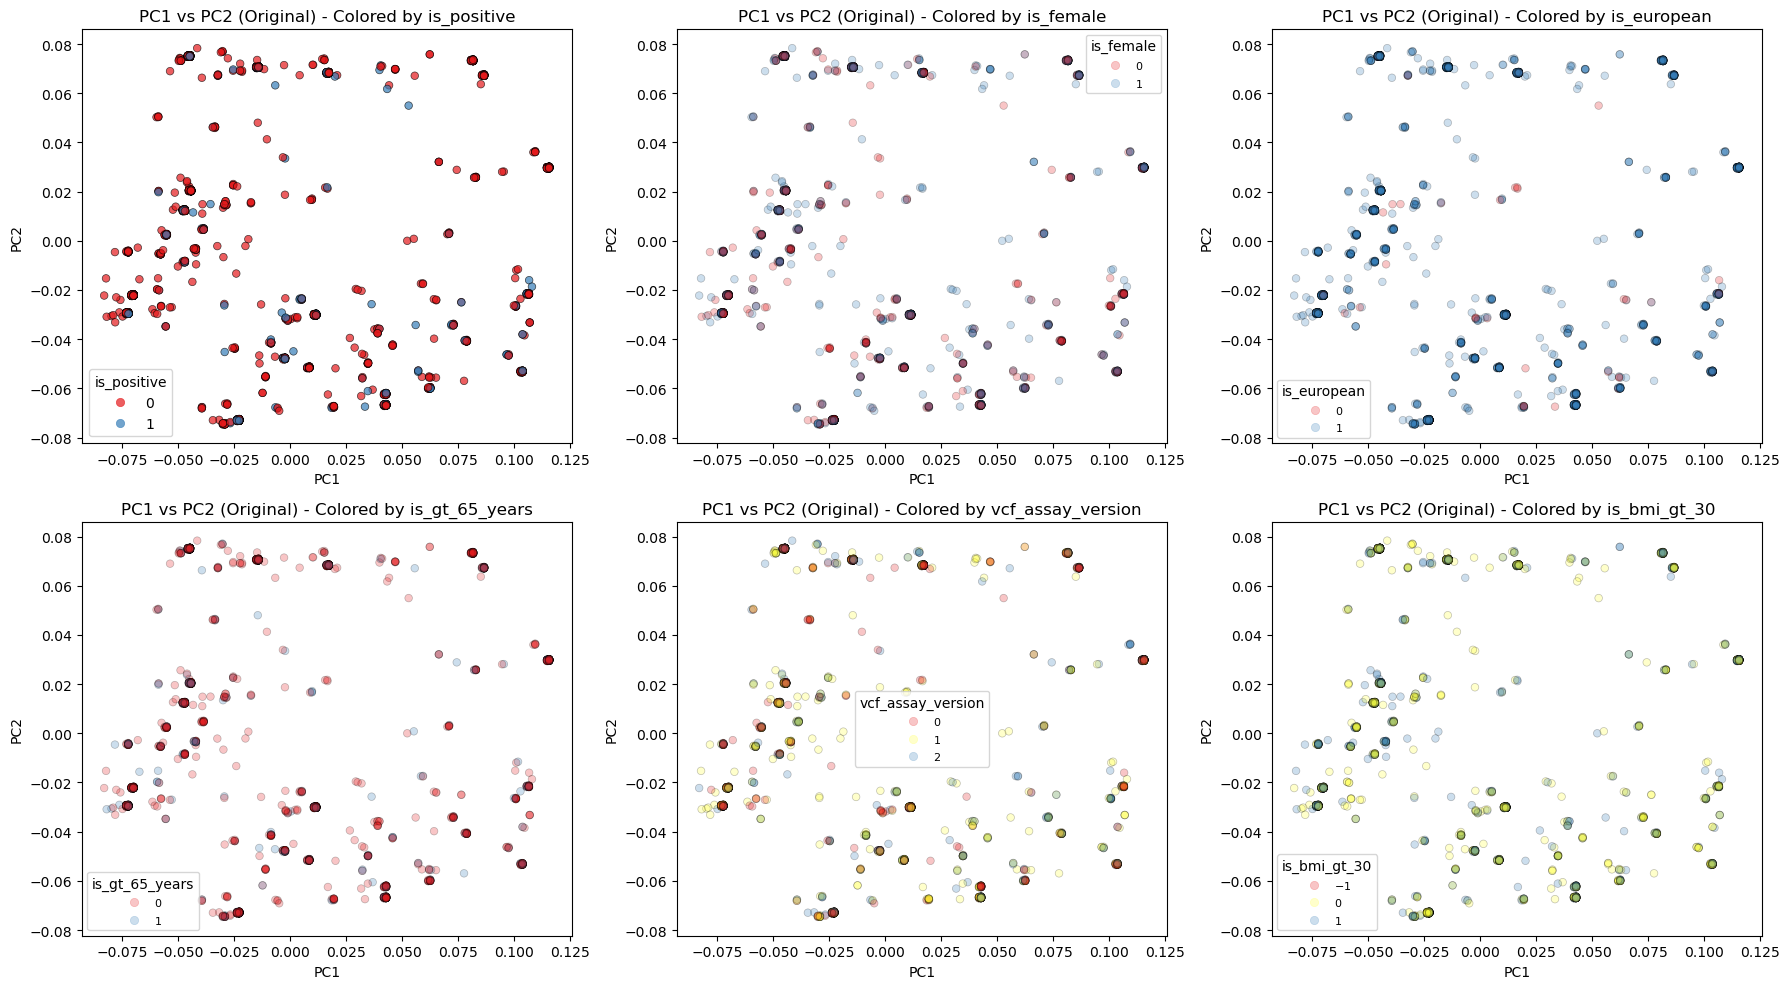

In [19]:
# Create multi-plot visualization of PC1 and PC2 vs confounders
from matplotlib.colors import ListedColormap
n_confounders = len(confounder_cols) + 1  # +1 for the main is_positive plot
n_cols = min(3, n_confounders)
n_rows = (n_confounders + n_cols - 1) // n_cols

# Use more contrasting colormaps
contrast_cmap = ListedColormap(["#e41a1c","#ffff33", "#377eb8",]) # "#4daf4a", "#984ea3", "#ff7f00", "#a65628", "#f781bf", "#999999"])
contrast_cmap_cont = "plasma"  # For continuous variables

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if n_confounders > 1 else [axes]

# Plot PC1 vs PC2 colored by is_positive (main outcome)
scatter = axes[0].scatter(df['PC1_original'], df['PC2_original'], 
                         c=df['is_positive'], cmap=contrast_cmap, 
                         alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PC1 vs PC2 (Original) - Colored by is_positive')
axes[0].legend(*scatter.legend_elements(), title="is_positive")

# Plot PC1 vs PC2 colored by each confounder
for idx, confounder in enumerate(confounder_cols, start=1):
    if idx >= len(axes):
        break
    
    # Check if confounder is categorical or continuous
    if df[confounder].dtype == 'object' or df[confounder].nunique() < 10:
        # Categorical - use discrete, high-contrast colors
        scatter = axes[idx].scatter(df['PC1_original'], df['PC2_original'], 
                                   c=pd.Categorical(df[confounder]).codes, 
                                   cmap=contrast_cmap, alpha=0.25, s=30, edgecolor='k', linewidth=0.5)
        axes[idx].legend(*scatter.legend_elements(), title=confounder, 
                        loc='best', fontsize=8)
    else:
        # Continuous - use a more vibrant colormap
        scatter = axes[idx].scatter(df['PC1_original'], df['PC2_original'], 
                                   c=df[confounder], cmap=contrast_cmap_cont, 
                                   alpha=0.25, s=30, edgecolor='k', linewidth=0.5)
        plt.colorbar(scatter, ax=axes[idx], label=confounder)
    
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')
    axes[idx].set_title(f'PC1 vs PC2 (Original) - Colored by {confounder}')

# Hide unused subplots
for idx in range(n_confounders, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('pca_original_confounders.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Train/Validation Split

**Critical**: We split by `case_matched` groups (not individual samples) to prevent data leakage.

If we randomly split individuals, a case and its matched controls might end up in different sets, allowing the model to "cheat" by learning confounder patterns that appear in both train and validation.

By keeping each case-control group together, we ensure the model generalizes to unseen confounder combinations.

In [20]:
train_only_mask = df['split'] == 'train'
df = df[train_only_mask]

missing_case_mask = df['matched_case_kitid'].isna()
df.loc[missing_case_mask, 'matched_case_kitid'] = df.loc[missing_case_mask, 'sample_id']

In [21]:
# Recreate train/val splits by matched_case_kitid groups
unique_groups = df['matched_case_kitid'].unique()
from sklearn.model_selection import train_test_split
train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)
train_mask = df['matched_case_kitid'].isin(train_groups)
val_mask = df['matched_case_kitid'].isin(val_groups)
df_train = df[train_mask].copy()
df_val = df[val_mask].copy()
print(f"Train set: {len(df_train)} samples ({df_train['is_positive'].sum()} positive)")
print(f"Val set: {len(df_val)} samples ({df_val['is_positive'].sum()} positive)")

Train set: 1408 samples (285 positive)
Val set: 359 samples (72 positive)


In [30]:
def extract_embeddings(df, embedding_cols):
    """
    Extract embeddings as a 2D numpy array (samples x embedding_dim).
    Handles columns that are arrays/lists or flat values.
    """
    # Check if all columns are scalar (float/int) for all rows
    is_scalar = all(
        df[col].map(lambda x: np.isscalar(x) or isinstance(x, (float, int))).all()
        for col in embedding_cols
    )
    if is_scalar:
        arr = df[embedding_cols].to_numpy(dtype=np.float32)
    else:
        arr = np.vstack([
            np.concatenate([np.array(row[col]).ravel() for col in embedding_cols])
            for _, row in df.iterrows()
        ]).astype(np.float32)
    if arr.ndim != 2:
        arr = arr.reshape(arr.shape[0], -1)
    return arr

X_train = extract_embeddings(df_train, embedding_cols)
y_train = df_train['is_positive'].values
case_matched_train = pd.factorize(df_train['matched_case_kitid'])[0]

X_val = extract_embeddings(df_val, embedding_cols)
y_val = df_val['is_positive'].values
case_matched_val = pd.factorize(df_val['matched_case_kitid'])[0]

input_dim = X_train.shape[1]

In [31]:
# Check if each factor in case_matched_train has exactly 5 samples
import collections
factor_counts = collections.Counter(case_matched_train)
print("Value counts for each factor in case_matched_train:")
print(factor_counts)
all_five = all(count == 5 for count in factor_counts.values())
print(f"All factors have exactly 5 samples? {all_five}")

Value counts for each factor in case_matched_train:
Counter({np.int64(0): 5, np.int64(1): 5, np.int64(2): 5, np.int64(3): 5, np.int64(4): 5, np.int64(5): 5, np.int64(6): 5, np.int64(7): 5, np.int64(8): 5, np.int64(9): 5, np.int64(10): 5, np.int64(11): 5, np.int64(12): 5, np.int64(13): 5, np.int64(14): 5, np.int64(15): 5, np.int64(16): 5, np.int64(17): 5, np.int64(18): 5, np.int64(19): 5, np.int64(20): 5, np.int64(21): 5, np.int64(22): 5, np.int64(23): 5, np.int64(24): 5, np.int64(25): 5, np.int64(26): 5, np.int64(27): 5, np.int64(28): 5, np.int64(29): 5, np.int64(30): 5, np.int64(31): 5, np.int64(32): 5, np.int64(33): 5, np.int64(34): 5, np.int64(35): 5, np.int64(36): 5, np.int64(37): 5, np.int64(38): 5, np.int64(39): 5, np.int64(41): 5, np.int64(42): 5, np.int64(43): 5, np.int64(44): 5, np.int64(45): 5, np.int64(46): 5, np.int64(47): 5, np.int64(48): 5, np.int64(49): 5, np.int64(50): 5, np.int64(51): 5, np.int64(52): 5, np.int64(53): 5, np.int64(54): 5, np.int64(55): 5, np.int64(56): 

## 4. PyTorch Contrastive Learning Architecture

### ContrastiveProjector
A 3-layer MLP that projects the input embeddings to a lower-dimensional space (128D) optimized for contrastive learning:
- **BatchNorm**: Stabilizes training and prevents internal covariate shift
- **Dropout**: Prevents overfitting to specific confounder patterns
- **L2 Normalization**: Output embeddings lie on unit hypersphere, making cosine similarity meaningful

### ContrastiveLoss
Supervised contrastive loss adapted for matched case-control design:
- Uses temperature-scaled cosine similarity
- Only considers pairs within the same `case_matched` group
- Pulls together samples with same label, pushes apart samples with different labels
- Automatically handles variable numbers of positive pairs per sample

In [32]:
class ContrastiveProjector(nn.Module):
    """
    Projection network for contrastive learning.
    Takes pre-computed embeddings and projects them to a lower-dimensional space
    optimized for discriminating between positive and negative cases while
    being invariant to confounders.
    """
    def __init__(self, input_dim, hidden_dim=256, output_dim=128, dropout=0.1):
        super(ContrastiveProjector, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return F.normalize(self.network(x), dim=1)  # L2 normalize for better contrastive learning


class ContrastiveLoss(nn.Module):
    """
    Supervised contrastive loss for matched case-control design.
    Positive pairs: same is_positive label AND same case_matched group
    Negative pairs: different is_positive label AND same case_matched group (matched controls)
    """
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, features, labels, case_matched):
        """
        Args:
            features: normalized embeddings, shape (batch_size, embed_dim)
            labels: is_positive labels, shape (batch_size,)
            case_matched: case_matched group IDs, shape (batch_size,)
        """
        device = features.device
        batch_size = features.shape[0]
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature
        
        # Create masks for positive and negative pairs
        labels = labels.contiguous().view(-1, 1)
        case_matched = case_matched.contiguous().view(-1, 1)
        
        # Positive mask: same label AND same case_matched group (but not same sample)
        label_mask = torch.eq(labels, labels.T).float().to(device)
        case_mask = torch.eq(case_matched, case_matched.T).float().to(device)
        positive_mask = label_mask * case_mask
        positive_mask.fill_diagonal_(0)  # Exclude self-comparisons
        
        # Negative mask: different label AND same case_matched group
        negative_mask = (1 - label_mask) * case_mask
        
        # For numerical stability
        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        logits = similarity_matrix - logits_max.detach()
        
        # Compute log probabilities
        exp_logits = torch.exp(logits) * (1 - torch.eye(batch_size).to(device))  # Exclude diagonal
        
        # Only consider negatives from same case_matched group
        log_prob = logits - torch.log(torch.sum(exp_logits * (positive_mask + negative_mask + 1e-8), dim=1, keepdim=True))
        
        # Compute mean of log-likelihood over positive pairs
        mean_log_prob_pos = (positive_mask * log_prob).sum(1) / (positive_mask.sum(1) + 1e-8)
        
        # Loss is negative log-likelihood
        loss = -mean_log_prob_pos
        loss = loss[positive_mask.sum(1) > 0].mean()  # Only compute loss for samples with positive pairs
        
        return loss

# Initialize model
input_dim = len(embedding_cols)
model = ContrastiveProjector(input_dim=input_dim, hidden_dim=256, output_dim=128).to(device)
criterion = ContrastiveLoss(temperature=0.07)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
ContrastiveProjector(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
  )
)

Total parameters: 100,480


## 5. Dataset and DataLoader

PyTorch dataset wrapper for the embeddings with custom collation to pass:
1. Pre-computed embeddings (input features)
2. Labels (`is_positive`)
3. Case-match group IDs (for contrastive loss computation)

The DataLoader shuffles training data while keeping batches reasonably sized to ensure diverse case-control groups per batch.

In [33]:
class EmbeddingDataset(Dataset):
    """Dataset for pre-computed embeddings with labels and case_matched groups"""
    def __init__(self, embeddings, labels, case_matched):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
        self.case_matched = torch.LongTensor(case_matched)
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx], self.case_matched[idx]


# Create datasets
train_dataset = EmbeddingDataset(
    X_train, 
    y_train, 
    case_matched_train
)

val_dataset = EmbeddingDataset(
    X_val, 
    y_val, 
    case_matched_val
)

# Create data loaders
# Use batch size that captures multiple cases with their controls (5 samples per case * batch)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 22
Val batches: 6


## 6. Monitoring Functions

We track two complementary metrics during training:

### 1. Calinski-Harabasz Index (Geometric)
Ratio of between-cluster variance to within-cluster variance. Higher values indicate better-defined, more separated clusters.
- **Formula**: (BSS / WSS) × ((N - k) / (k - 1)) where N = samples, k = classes
- **Advantage**: Fast, well-established, scale-invariant
- **Range**: [0, ∞), higher is better

### 2. Logistic Regression AUC (Discriminative)
Train a simple linear classifier on the embeddings and evaluate on validation set.
- **Advantage**: Measures actual downstream predictive utility
- **Limitation**: May underestimate quality if embeddings require non-linear classifier

By monitoring both metrics, we get a complete picture of embedding quality.

In [34]:
def compute_cluster_separation(embeddings, labels):
    """
    Compute Calinski-Harabasz Index (Variance Ratio Criterion).
    Measures the ratio of between-cluster to within-cluster variance.
    Higher values indicate better-defined clusters.
    
    Returns:
        float: CH index score (higher is better, range [0, inf))
    """
    if len(np.unique(labels)) < 2:
        return 0.0
    
    return calinski_harabasz_score(embeddings, labels)


def compute_logistic_auc(X_train, y_train, X_val, y_val):
    """
    Train a logistic regression classifier and return validation AUC.
    """
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc


def evaluate_embeddings(model, train_loader, val_loader, device):
    """
    Evaluate the quality of learned embeddings using cluster separation and AUC.
    """
    model.eval()
    
    # Get all train embeddings
    train_embeddings_list = []
    train_labels_list = []
    with torch.no_grad():
        for embeddings, labels, _ in train_loader:
            embeddings = embeddings.to(device)
            projected = model(embeddings)
            train_embeddings_list.append(projected.cpu().numpy())
            train_labels_list.append(labels.numpy())
    
    train_embeddings = np.vstack(train_embeddings_list)
    train_labels = np.concatenate(train_labels_list)
    
    # Get all val embeddings
    val_embeddings_list = []
    val_labels_list = []
    with torch.no_grad():
        for embeddings, labels, _ in val_loader:
            embeddings = embeddings.to(device)
            projected = model(embeddings)
            val_embeddings_list.append(projected.cpu().numpy())
            val_labels_list.append(labels.numpy())
    
    val_embeddings = np.vstack(val_embeddings_list)
    val_labels = np.concatenate(val_labels_list)
    
    # Compute metrics
    train_separation = compute_cluster_separation(train_embeddings, train_labels)
    val_separation = compute_cluster_separation(val_embeddings, val_labels)
    auc = compute_logistic_auc(train_embeddings, train_labels, val_embeddings, val_labels)
    
    return {
        'train_separation': train_separation,
        'val_separation': val_separation,
        'val_auc': auc,
        'train_embeddings': train_embeddings,
        'train_labels': train_labels,
        'val_embeddings': val_embeddings,
        'val_labels': val_labels
    }

print("Monitoring functions defined successfully!")

Monitoring functions defined successfully!


## 7. Training Loop

Train the projection network with:
- **AdamW optimizer**: Decoupled weight decay for better generalization
- **Cosine annealing schedule**: Gradually reduces learning rate for fine-tuning
- **Evaluation every 5 epochs**: Track cluster separation and AUC without slowing training
- **Best model selection**: Save model with highest validation AUC

**Note**: Some batches may have NaN loss if they don't contain valid positive pairs. These are safely skipped.

In [35]:
# Training hyperparameters
num_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-5

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_separation': [],
    'val_separation': [],
    'val_auc': []
}

print(f"Training for {num_epochs} epochs...")
print(f"Initial evaluation before training:")

Training for 50 epochs...
Initial evaluation before training:


In [36]:
# Baseline evaluation (before training)
baseline_metrics = evaluate_embeddings(model, train_loader, val_loader, device)
print(f"Baseline - Train Separation: {baseline_metrics['train_separation']:.4f}")
print(f"Baseline - Val Separation: {baseline_metrics['val_separation']:.4f}")
print(f"Baseline - Val AUC: {baseline_metrics['val_auc']:.4f}")
print()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2048 and 2x256)

In [51]:
# Main training loop
best_val_auc = 0
best_model_state = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_batches = 0
    
    for embeddings, labels, case_matched in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        case_matched = case_matched.to(device)
        
        # Forward pass
        projected = model(embeddings)
        loss = criterion(projected, labels, case_matched)
        
        # Skip if loss is nan (can happen if batch has no valid pairs)
        if torch.isnan(loss):
            continue
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    train_loss /= max(train_batches, 1)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for embeddings, labels, case_matched in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            case_matched = case_matched.to(device)
            
            projected = model(embeddings)
            loss = criterion(projected, labels, case_matched)
            
            if not torch.isnan(loss):
                val_loss += loss.item()
                val_batches += 1
    
    val_loss /= max(val_batches, 1)
    
    # Update learning rate
    scheduler.step()
    
    # Evaluate embeddings quality every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        metrics = evaluate_embeddings(model, train_loader, val_loader, device)
        
        history['train_separation'].append(metrics['train_separation'])
        history['val_separation'].append(metrics['val_separation'])
        history['val_auc'].append(metrics['val_auc'])
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Train Sep: {metrics['train_separation']:.4f} | Val Sep: {metrics['val_separation']:.4f}")
        print(f"  Val AUC: {metrics['val_auc']:.4f}")
        print()
        
        # Save best model
        if metrics['val_auc'] > best_val_auc:
            best_val_auc = metrics['val_auc']
            best_model_state = model.state_dict().copy()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

print(f"Training complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")

Epoch 1/50:   0%|          | 0/22 [00:00<?, ?it/s]



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2048 and 2x256)

In [ ]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation AUC")

## 8. Training History Visualization

Visualize three key metrics over training:

1. **Contrastive Loss**: Should decrease and stabilize
2. **Calinski-Harabasz Index**: Should increase as clusters become better separated
3. **Validation AUC**: Should improve, indicating better downstream utility

If CH index increases but AUC plateaus, the model may be overfitting to train-specific patterns.

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Contrastive Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calinski-Harabasz Index
eval_epochs = list(range(1, num_epochs+1, 5))
if 1 not in eval_epochs:
    eval_epochs = [1] + eval_epochs
axes[1].plot(eval_epochs[:len(history['train_separation'])], 
             history['train_separation'], marker='o', label='Train CH Index', linewidth=2)
axes[1].plot(eval_epochs[:len(history['val_separation'])], 
             history['val_separation'], marker='o', label='Val CH Index', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(eval_epochs[:len(history['val_auc'])], 
             history['val_auc'], marker='o', color='green', linewidth=2)
axes[2].axhline(y=0.5, color='red', linestyle='--', label='Random Baseline', alpha=0.5)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Validation AUC')
axes[2].set_title('Logistic Regression AUC on Learned Embeddings')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0.4, 1.0])

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Post-Training Embedding Analysis

Generate the final debiased embeddings by passing all samples through the trained projection network, then compare to the original embeddings.

### What to Look For:

**In the is_positive plots:**
- ✓ Clearer separation between cases (red) and controls (blue)
- ✓ Tighter within-class clusters

**In the confounder plots:**
- ✓ Reduced correlation with confounders (more mixed colors)
- ✓ Random scatter rather than clear gradients

If confounders still show strong patterns, consider:
- Longer training
- Stronger weight decay
- Explicit adversarial debiasing

In [ ]:
# Generate post-training embeddings for all data
model.eval()
all_embeddings = torch.FloatTensor(embeddings).to(device)

with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size_inference = 256
    trained_embeddings_list = []
    
    for i in range(0, len(all_embeddings), batch_size_inference):
        batch = all_embeddings[i:i+batch_size_inference]
        projected = model(batch)
        trained_embeddings_list.append(projected.cpu().numpy())
    
    trained_embeddings = np.vstack(trained_embeddings_list)

print(f"Generated trained embeddings: {trained_embeddings.shape}")

In [ ]:
# Perform PCA on trained embeddings
pca_trained = PCA(n_components=2)
pca_coords_trained = pca_trained.fit_transform(trained_embeddings)

# Add to dataframe
df['PC1_trained'] = pca_coords_trained[:, 0]
df['PC2_trained'] = pca_coords_trained[:, 1]

print(f"Trained embeddings - Explained variance ratio: {pca_trained.explained_variance_ratio_}")
print(f"Trained embeddings - Total variance explained: {pca_trained.explained_variance_ratio_.sum():.3f}")

In [ ]:
# Compare original vs trained embeddings - PC1 vs PC2 colored by is_positive
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original embeddings
scatter1 = axes[0].scatter(df['PC1_original'], df['PC2_original'], 
                          c=df['is_positive'], cmap='coolwarm', 
                          alpha=0.6, s=20)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Original Embeddings (Before Training)')
axes[0].legend(*scatter1.legend_elements(), title="is_positive")

# Trained embeddings
scatter2 = axes[1].scatter(df['PC1_trained'], df['PC2_trained'], 
                          c=df['is_positive'], cmap='coolwarm', 
                          alpha=0.6, s=20)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Trained Embeddings (After Contrastive Learning)')
axes[1].legend(*scatter2.legend_elements(), title="is_positive")

plt.tight_layout()
plt.savefig('pca_comparison_is_positive.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Multi-plot comparison: Original vs Trained for each confounder
n_confounders = len(confounder_cols) + 1  # +1 for is_positive
n_cols = min(3, n_confounders)
n_rows = (n_confounders + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(6*n_cols, 5*n_rows*2))
axes = axes.flatten() if n_confounders > 1 else [axes]

plot_idx = 0

# Plot is_positive first
for emb_type, pc1_col, pc2_col, title_suffix in [
    ('original', 'PC1_original', 'PC2_original', 'Original'),
    ('trained', 'PC1_trained', 'PC2_trained', 'Trained')
]:
    scatter = axes[plot_idx].scatter(df[pc1_col], df[pc2_col], 
                                    c=df['is_positive'], cmap='coolwarm', 
                                    alpha=0.6, s=20)
    axes[plot_idx].set_xlabel('PC1')
    axes[plot_idx].set_ylabel('PC2')
    axes[plot_idx].set_title(f'PC1 vs PC2 ({title_suffix}) - is_positive')
    axes[plot_idx].legend(*scatter.legend_elements(), title="is_positive", fontsize=8)
    plot_idx += 1

# Plot each confounder
for confounder in confounder_cols:
    for emb_type, pc1_col, pc2_col, title_suffix in [
        ('original', 'PC1_original', 'PC2_original', 'Original'),
        ('trained', 'PC1_trained', 'PC2_trained', 'Trained')
    ]:
        if plot_idx >= len(axes):
            break
            
        # Check if confounder is categorical or continuous
        if df[confounder].dtype == 'object' or df[confounder].nunique() < 10:
            # Categorical
            scatter = axes[plot_idx].scatter(df[pc1_col], df[pc2_col], 
                                           c=pd.Categorical(df[confounder]).codes, 
                                           cmap='tab10', alpha=0.6, s=20)
            axes[plot_idx].legend(*scatter.legend_elements(), title=confounder, 
                                loc='best', fontsize=8)
        else:
            # Continuous
            scatter = axes[plot_idx].scatter(df[pc1_col], df[pc2_col], 
                                           c=df[confounder], cmap='viridis', 
                                           alpha=0.6, s=20)
            plt.colorbar(scatter, ax=axes[plot_idx], label=confounder)
        
        axes[plot_idx].set_xlabel('PC1')
        axes[plot_idx].set_ylabel('PC2')
        axes[plot_idx].set_title(f'PC1 vs PC2 ({title_suffix}) - {confounder}')
        plot_idx += 1

# Hide unused subplots
for idx in range(plot_idx, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('pca_comparison_all_confounders.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization complete! Check the saved PNG files for detailed comparisons.")

## 10. Summary and Export

### Final Metrics
Quantify the improvement achieved by contrastive learning:
- **Cluster separation improvement**: How much better are cases/controls separated?
- **AUC improvement**: Is the embedding more useful for downstream prediction?

### Saving Results
Optionally save:
1. **Trained embeddings**: For use in downstream analyses (GWAS, prediction models, etc.)
2. **Model weights**: To apply the same transformation to new samples

### Next Steps
With the debiased embeddings, you can:
- Run association studies with reduced confounding
- Train fairer predictive models
- Perform clustering or dimensionality reduction with less technical artifact

In [ ]:
# Final evaluation on all data
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\nBest validation AUC achieved: {best_val_auc:.4f}")
print(f"\nOriginal embeddings:")
print(f"  Shape: {embeddings.shape}")
print(f"  PCA variance explained (PC1+PC2): {pca_original.explained_variance_ratio_.sum():.3f}")

print(f"\nTrained embeddings:")
print(f"  Shape: {trained_embeddings.shape}")
print(f"  PCA variance explained (PC1+PC2): {pca_trained.explained_variance_ratio_.sum():.3f}")

# Compute final metrics on full dataset
final_ch_original = compute_cluster_separation(embeddings, df['is_positive'].values)
final_ch_trained = compute_cluster_separation(trained_embeddings, df['is_positive'].values)

print(f"\nCalinski-Harabasz Index (higher is better):")
print(f"  Original embeddings: {final_ch_original:.2f}")
print(f"  Trained embeddings: {final_ch_trained:.2f}")
print(f"  Improvement: {((final_ch_trained - final_ch_original) / final_ch_original * 100):.2f}%")

print("\n" + "=" * 60)
print("Files saved:")
print("  - pca_original_confounders.png")
print("  - training_history.png")
print("  - pca_comparison_is_positive.png")
print("  - pca_comparison_all_confounders.png")
print("=" * 60)

In [ ]:
# Optional: Save trained embeddings and model
# Uncomment to save

# # Save trained embeddings to parquet
# df_export = df.copy()
# for i in range(trained_embeddings.shape[1]):
#     df_export[f'trained_emb_{i}'] = trained_embeddings[:, i]
# df_export.to_parquet('embeddings_with_trained.parquet', index=False)
# print("Saved embeddings with trained representations to 'embeddings_with_trained.parquet'")

# # Save model weights
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'input_dim': input_dim,
#     'hidden_dim': 256,
#     'output_dim': 128,
#     'best_val_auc': best_val_auc
# }, 'contrastive_model.pt')
# print("Saved model weights to 'contrastive_model.pt'")